In [25]:
from typing import TypedDict, Annotated, Sequence
import operator
import math

from langgraph.graph import StateGraph, END

from langgraph.checkpoint.memory import InMemorySaver


from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool


In [26]:
class TaskManagerState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    
    tasks: list[dict]
    
    # task_history: list[str]
    

In [27]:
counter=0

In [28]:
@tool
def add_task(title: str, priority: str ='medium') -> str:
    """ add a new task to the list"""
    global counter
    counter += 1
    print(f"Task {title} added with priority {priority}")
    return {'id': counter,
            'title':title,
            'priority':priority,
            'status':'pending'}
 

@tool
def remove_task(task_id: int) -> str:
    """ deletes the task based on the task_id"""
    print(f"Task {task_id} removed successfully")
    return {'id':task_id}


@tool
def update_task(task_id: int, title: str = None, priority: str = None) -> str:
    """Update task title or priority"""
    print(f"Task {task_id} updated successfully")
    return {"id": task_id, "title": title, "priority": priority}


tools = [add_task, remove_task,update_task]
    
    

In [29]:
from dotenv import load_dotenv
load_dotenv()

# Method 4: Pass api_key directly to ChatOpenAI (not recommended)
# llm = ChatOpenAI(model="gpt-4", temperature=0, api_key="your-api-key-here")
model_name= "gpt-4.1-mini"
# Create the base LLM (temperature=0 for deterministic responses)
llm = ChatOpenAI(model=model_name, temperature=0)

# Bind the calculation tools to the LLM
# This enables the model to call these tools when needed
llm_with_tools = llm.bind_tools(tools)

print("✓ Language model initialized with tools")
print(f"  Model: {model_name}")
print(f"  Available tools: {len(tools)}")

✓ Language model initialized with tools
  Model: gpt-4.1-mini
  Available tools: 3


In [30]:
def call_model(state: TaskManagerState) -> dict:
    """
    This node calls the LLM with the current conversation history.
    The LLM will either:
    - Call one or more tools (for calculations)
    - Respond with a final answer (no more tools needed)
    """
    messages = state["messages"]
    print(f"""Step1: Run the call_model function with message as {state["messages"]}""")
    
    # Invoke the LLM with tools
    response = llm_with_tools.invoke(messages)
    print(f"Response from 'llm_with_tools.invoke(messages)' command is {response}\n")
    # Return the response as a new message to be added to state
    return {"messages": [response]}


def call_tools(state: TaskManagerState) -> dict:
    """This node executes all tool calls from the last agent message.
        It runs the actual task tools and returns the results.
    """
    
    messages = state["messages"]
    last_messages = messages[-1]
    
    print("Step3: Run the call_tolls function ")
    print(f"In call_tolls, message from state['message] is {messages}\n")
    
    tool_calls = last_messages.tool_calls
    
    tool_map = {tool.name:tool for tool in tools}
    
    tool_messages=[]
    tasks = state.get('tasks',[])
    
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
    
        selected_tool = tool_map[tool_name]
    
        try:
            result = selected_tool.invoke(tool_args)
        #    task_record = f"{tool_name}({', '.join(map(str, tool_args.values()))}) = {result}"
            if tool_name=='add_task':
               tasks.append(result)
               
            if tool_name=='remove_task' and len(tasks)>0:
               tasks = [task for task in tasks if task.get('id') != result['id']]
            
            if tool_name == 'update_task' and len(tasks)>0:
                task_to_be_updated = [task for task in tasks if task.get('id')==result['id']]
                matching_task = task_to_be_updated[0]
    
                if result.get('title') is not None:  # ← Check RESULT
                    matching_task['title'] = result['title']
    
                if result.get('priority') is not None:  # ← Check RESULT
                      matching_task['priority'] = result['priority']
    
                tasks = [task if task.get('id') != result['id'] else matching_task for task in tasks]
                
               
                
            tool_messages.append(
               ToolMessage(
                   content=str(result),
                   tool_call_id = tool_id,
                   name=tool_name))
           
        except Exception as e:
            # Handle any errors during tool execution
               tool_messages.append(
                ToolMessage(
                content=f"Error: {str(e)}",
                tool_call_id=tool_id,
                name=tool_name
            )
        )
        
    return {
        "messages": tool_messages,
        "tasks": tasks
    }
    
    
def should_continue(state: TaskManagerState) -> str:
    """
    This function checks if the agent wants to use more tools.
    If there are tool calls in the last message, we continue to the tools node.
    Otherwise, we end the execution.
    """
    
    print("Now, we have entered into should_continue function. After call_model and before should_contninue, langGraph appends the state['mesage']  based the state['message] + response from lllm_with_tools.invoke(messages)")
    
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if there are any tool calls in the last message
    if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
        print("Step2: Run the should_continue function -- END")
        print(f"In should_continue, message from state['message] is {messages}\n")
        return "end"  # No more tools to call, we're done
    
    print("Step2: Run the should_continue function -- CONTINUE")
    print(f"In should_continue, message from state['message] is {messages}\n")
    
    return "continue"  # More tools to execute

In [ ]:
checkpointer = InMemorySaver()
# This is created once before compiling the graph
# When we run it again, the checkpointer memory will be reset
# Now, when we ask questiosn, we only invoke the graph and not compile it again. Hence, memory is preserved during the session

In [32]:
# Function to create and compile the task manager graph
def create_taskmanager_graph():
    """
    Build the LangGraph calculator agent.
    Returns a compiled graph ready for execution.
    """
    
    # Initialize the StateGraph with our state schema
    workflow = StateGraph(TaskManagerState)
    
    # Add nodes to the graph
    # "agent" node: calls the LLM to make decisions
    workflow.add_node("TaskAgent", call_model)
    
    # "tools" node: executes the calculation tools
    workflow.add_node("TaskTools", call_tools)
    
    # Set the entry point (where execution starts)
    workflow.set_entry_point("TaskAgent")
    
    # Add conditional edges from agent node
    # Based on should_continue(), either go to tools or END
    workflow.add_conditional_edges(
        "TaskAgent",  # From the agent node
        should_continue,  # Use this function to decide
        {
            "continue": "TaskTools",  # If continue, go to tools node
            "end": END  # If end, finish execution
        }
    )
    
    # Add edge from tools back to agent
    # This creates the loop: agent → tools → agent → ...
    workflow.add_edge("TaskTools", "TaskAgent")
    
    # Compile the graph into an executable form
    return workflow.compile(checkpointer=checkpointer)

In [33]:
# Create the graph
taskmanager_graph = create_taskmanager_graph()

print("TaskManagement graph created and compiled!")
print("Graph structure:")
print("  START → agent → [conditional] → tools → agent → ... → END")

TaskManagement graph created and compiled!
Graph structure:
  START → agent → [conditional] → tools → agent → ... → END


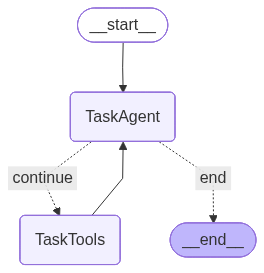

In [34]:
taskmanager_graph

In [35]:
# Helper function to run the calculator agent with a question
def run_taskmanager_agent(question: str, thread_id:str = "conversation_1" ,verbose: bool = True):
    """
    Run the calculator agent with a user question.
    
    Args:
        question: The user's calculation question in natural language
        verbose: If True, print detailed output
    
    Returns:
        The final state containing all messages and calculation history
    """
    
    config = {"configurable": {"thread_id": thread_id}}
    
    try:
        # Get the last checkpoint for this thread
        previous_state = taskmanager_graph.get_state(config)
        existing_tasks = previous_state.values.get('tasks', [])
        print(f"📂 Loaded {len(existing_tasks)} task(s) from previous session")
    except:
        existing_tasks = []
        print("📝 Starting with empty task list")
         
    
    # Initialize the state with the user's question
    initial_state = {
        "messages": [HumanMessage(content=question)],
        "tasks": existing_tasks
    }
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"Question: {question}")
        print(f"{'='*70}\n")
    
    # Invoke the graph with the initial state
    # The graph will run until it reaches END
    
    # result = taskmanager_graph.invoke(initial_state)
    
    result = taskmanager_graph.invoke(initial_state, config=config)
    
    
    if verbose:
        # Display all calculation steps
        if result.get("tasks"):
            print("tasks Steps:")
            for i, calc in enumerate(result["tasks"], 1):
                print(f"   {i}. {calc}")
            print()
        
        # Display the final answer from the agent
        final_message = result["messages"][-1]
        print(f"Final Answer: {final_message.content}\n")
    
    return result


print("Helper function ready to use")

Helper function ready to use


In [36]:
myresult = run_taskmanager_agent("""add task to bring milk as high priority, then add task to clean the house as medium priority. \
                                Now, delete task 1 and update priority of task 2 to very high""")

📂 Loaded 0 task(s) from previous session

Question: add task to bring milk as high priority, then add task to clean the house as medium priority.                                 Now, delete task 1 and update priority of task 2 to very high

Step1: Run the call_model function with message as [HumanMessage(content='add task to bring milk as high priority, then add task to clean the house as medium priority.                                 Now, delete task 1 and update priority of task 2 to very high', additional_kwargs={}, response_metadata={})]
Response from 'llm_with_tools.invoke(messages)' command is content='' additional_kwargs={'tool_calls': [{'id': 'call_SZTgYzSp95cg4cJIgKMsnQ3q', 'function': {'arguments': '{"title": "bring milk", "priority": "high"}', 'name': 'add_task'}, 'type': 'function'}, {'id': 'call_0HxKzxav5TQPjotno8TKS46q', 'function': {'arguments': '{"title": "clean the house", "priority": "medium"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None} response_me

In [37]:
myresult

{'messages': [HumanMessage(content='add task to bring milk as high priority, then add task to clean the house as medium priority.                                 Now, delete task 1 and update priority of task 2 to very high', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SZTgYzSp95cg4cJIgKMsnQ3q', 'function': {'arguments': '{"title": "bring milk", "priority": "high"}', 'name': 'add_task'}, 'type': 'function'}, {'id': 'call_0HxKzxav5TQPjotno8TKS46q', 'function': {'arguments': '{"title": "clean the house", "priority": "medium"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 161, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-min

In [38]:
checkpointer.blobs

defaultdict(None,
            {('conversation_1',
              '',
              '__start__',
              '00000000000000000000000000000001.0.747495530266731'): ('msgpack',
              b'\x82\xa8messages\x91\xc8\x01J\x05\x94\xbdlangchain_core.messages.human\xacHumanMessage\x87\xa7content\xd9\xbbadd task to bring milk as high priority, then add task to clean the house as medium priority.                                 Now, delete task 1 and update priority of task 2 to very high\xb1additional_kwargs\x80\xb1response_metadata\x80\xa4type\xa5human\xa4name\xc0\xa2id\xc0\xa7example\xc2\xb3model_validate_json\xa5tasks\x90'),
             ('conversation_1',
              '',
              '__start__',
              '00000000000000000000000000000002.0.6912801200961279'): ('empty',
              b''),
             ('conversation_1',
              '',
              'messages',
              '00000000000000000000000000000002.0.6912801200961279'): ('msgpack',
              b'\x91\xc8\x01J\x05

In [39]:
myresult = run_taskmanager_agent("""What task did I delete ?""")

📂 Loaded 1 task(s) from previous session

Question: What task did I delete ?

Step1: Run the call_model function with message as [HumanMessage(content='add task to bring milk as high priority, then add task to clean the house as medium priority.                                 Now, delete task 1 and update priority of task 2 to very high', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SZTgYzSp95cg4cJIgKMsnQ3q', 'function': {'arguments': '{"title": "bring milk", "priority": "high"}', 'name': 'add_task'}, 'type': 'function'}, {'id': 'call_0HxKzxav5TQPjotno8TKS46q', 'function': {'arguments': '{"title": "clean the house", "priority": "medium"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 161, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_pre

In [40]:
checkpointer.blobs

defaultdict(None,
            {('conversation_1',
              '',
              '__start__',
              '00000000000000000000000000000001.0.747495530266731'): ('msgpack',
              b'\x82\xa8messages\x91\xc8\x01J\x05\x94\xbdlangchain_core.messages.human\xacHumanMessage\x87\xa7content\xd9\xbbadd task to bring milk as high priority, then add task to clean the house as medium priority.                                 Now, delete task 1 and update priority of task 2 to very high\xb1additional_kwargs\x80\xb1response_metadata\x80\xa4type\xa5human\xa4name\xc0\xa2id\xc0\xa7example\xc2\xb3model_validate_json\xa5tasks\x90'),
             ('conversation_1',
              '',
              '__start__',
              '00000000000000000000000000000002.0.6912801200961279'): ('empty',
              b''),
             ('conversation_1',
              '',
              'messages',
              '00000000000000000000000000000002.0.6912801200961279'): ('msgpack',
              b'\x91\xc8\x01J\x05

In [41]:
myresult = run_taskmanager_agent("""What was its task id ?""")

📂 Loaded 1 task(s) from previous session

Question: What was its task id ?

Step1: Run the call_model function with message as [HumanMessage(content='add task to bring milk as high priority, then add task to clean the house as medium priority.                                 Now, delete task 1 and update priority of task 2 to very high', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SZTgYzSp95cg4cJIgKMsnQ3q', 'function': {'arguments': '{"title": "bring milk", "priority": "high"}', 'name': 'add_task'}, 'type': 'function'}, {'id': 'call_0HxKzxav5TQPjotno8TKS46q', 'function': {'arguments': '{"title": "clean the house", "priority": "medium"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 161, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_predi

In [42]:
checkpointer.blobs

defaultdict(None,
            {('conversation_1',
              '',
              '__start__',
              '00000000000000000000000000000001.0.747495530266731'): ('msgpack',
              b'\x82\xa8messages\x91\xc8\x01J\x05\x94\xbdlangchain_core.messages.human\xacHumanMessage\x87\xa7content\xd9\xbbadd task to bring milk as high priority, then add task to clean the house as medium priority.                                 Now, delete task 1 and update priority of task 2 to very high\xb1additional_kwargs\x80\xb1response_metadata\x80\xa4type\xa5human\xa4name\xc0\xa2id\xc0\xa7example\xc2\xb3model_validate_json\xa5tasks\x90'),
             ('conversation_1',
              '',
              '__start__',
              '00000000000000000000000000000002.0.6912801200961279'): ('empty',
              b''),
             ('conversation_1',
              '',
              'messages',
              '00000000000000000000000000000002.0.6912801200961279'): ('msgpack',
              b'\x91\xc8\x01J\x05

In [43]:
myresult = run_taskmanager_agent("""Can you add it again ?""")

📂 Loaded 1 task(s) from previous session

Question: Can you add it again ?

Step1: Run the call_model function with message as [HumanMessage(content='add task to bring milk as high priority, then add task to clean the house as medium priority.                                 Now, delete task 1 and update priority of task 2 to very high', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SZTgYzSp95cg4cJIgKMsnQ3q', 'function': {'arguments': '{"title": "bring milk", "priority": "high"}', 'name': 'add_task'}, 'type': 'function'}, {'id': 'call_0HxKzxav5TQPjotno8TKS46q', 'function': {'arguments': '{"title": "clean the house", "priority": "medium"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 161, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_predi

In [ ]:
# In should_continue, message from state['message] is
#1 [HumanMessage(content='add task to bring milk as high priority, then add task to clean the house as medium priority.Now, delete task 1 and update priority of task 2 to very high', additional_kwargs={}, response_metadata={}), 
#2 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SZTgYzSp95cg4cJIgKMsnQ3q', 'function': {'arguments': '{"title": "bring milk", "priority": "high"}', 'name': 'add_task'}, 'type': 'function'}, {'id': 'call_0HxKzxav5TQPjotno8TKS46q', 'function': {'arguments': '{"title": "clean the house", "priority": "medium"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 161, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--22a45353-08c5-4c10-ac71-4be806007dff-0', tool_calls=[{'name': 'add_task', 'args': {'title': 'bring milk', 'priority': 'high'}, 'id': 'call_SZTgYzSp95cg4cJIgKMsnQ3q', 'type': 'tool_call'}, {'name': 'add_task', 'args': {'title': 'clean the house', 'priority': 'medium'}, 'id': 'call_0HxKzxav5TQPjotno8TKS46q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 161, 'output_tokens': 55, 'total_tokens': 216, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 
#3 ToolMessage(content="{'id': 1, 'title': 'bring milk', 'priority': 'high', 'status': 'pending'}", name='add_task', tool_call_id='call_SZTgYzSp95cg4cJIgKMsnQ3q'), 
#4 ToolMessage(content="{'id': 2, 'title': 'clean the house', 'priority': 'medium', 'status': 'pending'}", name='add_task', tool_call_id='call_0HxKzxav5TQPjotno8TKS46q'), 
#5 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MsDBY7gVpUDMPErFuECHeDhj', 'function': {'arguments': '{"task_id": 1}', 'name': 'remove_task'}, 'type': 'function'}, {'id': 'call_acYOAQ7AILoVIG0SEEVqO36o', 'function': {'arguments': '{"task_id": 2, "priority": "very high"}', 'name': 'update_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 281, 'total_tokens': 332, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b0db6043-94c0-4e54-9757-ee9a4f473aaf-0', tool_calls=[{'name': 'remove_task', 'args': {'task_id': 1}, 'id': 'call_MsDBY7gVpUDMPErFuECHeDhj', 'type': 'tool_call'}, {'name': 'update_task', 'args': {'task_id': 2, 'priority': 'very high'}, 'id': 'call_acYOAQ7AILoVIG0SEEVqO36o', 'type': 'tool_call'}], usage_metadata={'input_tokens': 281, 'output_tokens': 51, 'total_tokens': 332, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
#6 ToolMessage(content="{'id': 1}", name='remove_task', tool_call_id='call_MsDBY7gVpUDMPErFuECHeDhj'), 
#7 ToolMessage(content="{'id': 2, 'title': None, 'priority': 'very high'}", name='update_task', tool_call_id='call_acYOAQ7AILoVIG0SEEVqO36o'), 
#8 AIMessage(content='The task to bring milk has been added with high priority and then deleted. The task to clean the house was added with medium priority and its priority has now been updated to very high.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 369, 'total_tokens': 407, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'stop', 'logprobs': None}, id='run--87b7d7a8-bd17-4770-a6ff-b1cf56ebb162-0', usage_metadata={'input_tokens': 369, 'output_tokens': 38, 'total_tokens': 407, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 
#9 HumanMessage(content='What task did I delete ?', additional_kwargs={}, response_metadata={}), 
#10 AIMessage(content='You deleted the task "bring milk."', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 420, 'total_tokens': 429, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'stop', 'logprobs': None}, id='run--504319f8-9062-4686-8019-144f821c95e2-0', usage_metadata={'input_tokens': 420, 'output_tokens': 9, 'total_tokens': 429, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 
#11 HumanMessage(content='What was its task id ?', additional_kwargs={}, response_metadata={}), 
#12 AIMessage(content='The task ID of the deleted task "bring milk" was 1.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 442, 'total_tokens': 458, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'stop', 'logprobs': None}, id='run--e782100a-13d2-4345-b442-921382660dec-0', usage_metadata={'input_tokens': 442, 'output_tokens': 16, 'total_tokens': 458, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
#13 HumanMessage(content='Can you add it again ?', additional_kwargs={}, response_metadata={}), 
#14 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T7MDMh4u9tYBCFK1rRsd9xWx', 'function': {'arguments': '{"title":"bring milk","priority":"high"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 471, 'total_tokens': 490, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e54fde82-a2fa-4ab8-a7cb-5015e48fac62-0', tool_calls=[{'name': 'add_task', 'args': {'title': 'bring milk', 'priority': 'high'}, 'id': 'call_T7MDMh4u9tYBCFK1rRsd9xWx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 471, 'output_tokens': 19, 'total_tokens': 490, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})
# ]

In [ ]:
## Above and below hve same state['message'] 
## because between step2 and step3 only controlled has passed from agent to tools depending on the action: continue or end. state['message'] didnt change

# In call_tolls, message from state['message] is
#1 [HumanMessage(content='add task to bring milk as high priority, then add task to clean the house as medium priority.Now, delete task 1 and update priority of task 2 to very high', additional_kwargs={}, response_metadata={}), 
#2 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SZTgYzSp95cg4cJIgKMsnQ3q', 'function': {'arguments': '{"title": "bring milk", "priority": "high"}', 'name': 'add_task'}, 'type': 'function'}, {'id': 'call_0HxKzxav5TQPjotno8TKS46q', 'function': {'arguments': '{"title": "clean the house", "priority": "medium"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 161, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--22a45353-08c5-4c10-ac71-4be806007dff-0', tool_calls=[{'name': 'add_task', 'args': {'title': 'bring milk', 'priority': 'high'}, 'id': 'call_SZTgYzSp95cg4cJIgKMsnQ3q', 'type': 'tool_call'}, {'name': 'add_task', 'args': {'title': 'clean the house', 'priority': 'medium'}, 'id': 'call_0HxKzxav5TQPjotno8TKS46q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 161, 'output_tokens': 55, 'total_tokens': 216, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 
#3 ToolMessage(content="{'id': 1, 'title': 'bring milk', 'priority': 'high', 'status': 'pending'}", name='add_task', tool_call_id='call_SZTgYzSp95cg4cJIgKMsnQ3q'), 
#4 ToolMessage(content="{'id': 2, 'title': 'clean the house', 'priority': 'medium', 'status': 'pending'}", name='add_task', tool_call_id='call_0HxKzxav5TQPjotno8TKS46q'), 
#5 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MsDBY7gVpUDMPErFuECHeDhj', 'function': {'arguments': '{"task_id": 1}', 'name': 'remove_task'}, 'type': 'function'}, {'id': 'call_acYOAQ7AILoVIG0SEEVqO36o', 'function': {'arguments': '{"task_id": 2, "priority": "very high"}', 'name': 'update_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 281, 'total_tokens': 332, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b0db6043-94c0-4e54-9757-ee9a4f473aaf-0', tool_calls=[{'name': 'remove_task', 'args': {'task_id': 1}, 'id': 'call_MsDBY7gVpUDMPErFuECHeDhj', 'type': 'tool_call'}, {'name': 'update_task', 'args': {'task_id': 2, 'priority': 'very high'}, 'id': 'call_acYOAQ7AILoVIG0SEEVqO36o', 'type': 'tool_call'}], usage_metadata={'input_tokens': 281, 'output_tokens': 51, 'total_tokens': 332, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 
#6 ToolMessage(content="{'id': 1}", name='remove_task', tool_call_id='call_MsDBY7gVpUDMPErFuECHeDhj'), 
#7 ToolMessage(content="{'id': 2, 'title': None, 'priority': 'very high'}", name='update_task', tool_call_id='call_acYOAQ7AILoVIG0SEEVqO36o'), 
#8 AIMessage(content='The task to bring milk has been added with high priority and then deleted. The task to clean the house was added with medium priority and its priority has now been updated to very high.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 369, 'total_tokens': 407, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'stop', 'logprobs': None}, id='run--87b7d7a8-bd17-4770-a6ff-b1cf56ebb162-0', usage_metadata={'input_tokens': 369, 'output_tokens': 38, 'total_tokens': 407, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 
#9 HumanMessage(content='What task did I delete ?', additional_kwargs={}, response_metadata={}), 
#10 AIMessage(content='You deleted the task "bring milk."', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 420, 'total_tokens': 429, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'stop', 'logprobs': None}, id='run--504319f8-9062-4686-8019-144f821c95e2-0', usage_metadata={'input_tokens': 420, 'output_tokens': 9, 'total_tokens': 429, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 
#11 HumanMessage(content='What was its task id ?', additional_kwargs={}, response_metadata={}), 
#12 AIMessage(content='The task ID of the deleted task "bring milk" was 1.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 442, 'total_tokens': 458, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'stop', 'logprobs': None}, id='run--e782100a-13d2-4345-b442-921382660dec-0', usage_metadata={'input_tokens': 442, 'output_tokens': 16, 'total_tokens': 458, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 
#13 HumanMessage(content='Can you add it again ?', additional_kwargs={}, response_metadata={}), 
#14 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T7MDMh4u9tYBCFK1rRsd9xWx', 'function': {'arguments': '{"title":"bring milk","priority":"high"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 471, 'total_tokens': 490, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e54fde82-a2fa-4ab8-a7cb-5015e48fac62-0', tool_calls=[{'name': 'add_task', 'args': {'title': 'bring milk', 'priority': 'high'}, 'id': 'call_T7MDMh4u9tYBCFK1rRsd9xWx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 471, 'output_tokens': 19, 'total_tokens': 490, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]


In [44]:
myresult

{'messages': [HumanMessage(content='add task to bring milk as high priority, then add task to clean the house as medium priority.                                 Now, delete task 1 and update priority of task 2 to very high', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SZTgYzSp95cg4cJIgKMsnQ3q', 'function': {'arguments': '{"title": "bring milk", "priority": "high"}', 'name': 'add_task'}, 'type': 'function'}, {'id': 'call_0HxKzxav5TQPjotno8TKS46q', 'function': {'arguments': '{"title": "clean the house", "priority": "medium"}', 'name': 'add_task'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 161, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-min

In [45]:
myresult.keys()

dict_keys(['messages', 'tasks'])

In [46]:
checkpointer.blobs

defaultdict(None,
            {('conversation_1',
              '',
              '__start__',
              '00000000000000000000000000000001.0.747495530266731'): ('msgpack',
              b'\x82\xa8messages\x91\xc8\x01J\x05\x94\xbdlangchain_core.messages.human\xacHumanMessage\x87\xa7content\xd9\xbbadd task to bring milk as high priority, then add task to clean the house as medium priority.                                 Now, delete task 1 and update priority of task 2 to very high\xb1additional_kwargs\x80\xb1response_metadata\x80\xa4type\xa5human\xa4name\xc0\xa2id\xc0\xa7example\xc2\xb3model_validate_json\xa5tasks\x90'),
             ('conversation_1',
              '',
              '__start__',
              '00000000000000000000000000000002.0.6912801200961279'): ('empty',
              b''),
             ('conversation_1',
              '',
              'messages',
              '00000000000000000000000000000002.0.6912801200961279'): ('msgpack',
              b'\x91\xc8\x01J\x05